# Yandex Cup 22

RecSys - Like prediction

Важной задачей музыкальных рекомендаций является поиск неизвестных пользователю треков, которые ему понравятся. В решении этой задачи важную роль играют модели, анализирующие явный фидбэк пользователя. Явным фидбэком мы считаем такие события как like или dislike, поставленный на трек. Такие действия как play и skip также используются в рекомендациях, но они дают меньше информации о предпочтениях пользователя. Кроме того, гораздо важнее найти трек, которому пользователь поставит лайк, чем трек, который пользователь просто послушает. В этой задаче от вас требуется по предыдущим лайкам предсказать следующий трек, которому пользователь поставит лайк.

Формат ввода
Прдоставленные вам данные вы можете найти по ссылке
В архиве likes_data.zip три файла:
 - train - обучающий набор данных. Каждая строка - последовательность id треков, которые лайкнул один пользователь. Гарантируется, что лайки даны в той последовательности, в которой их ставил пользователь.
 - test - набор тестовых данных. Имеет точно такой же формат, но в каждой строке не хватает последнего лайка, который надо предсказать.
Тестовые данные разбита на public и private. Во время соревнования вы будет видеть результаты только на public данных. Финальный подсчет баллов в будет происходить на private данных.
 - track_artists.csv - информация о исполнителях треков. Гарантируется, что у каждого трека есть ровно один исполнитель. Для треков, у которых фактически несколько исполнителей, мы оставили того, который считается основным исполнителем трека.
 
 
Файл baseline.py содержит наивное решение. Обратите внимание, что это решение может выполняться больше одного часа.


Файл score.py содержит код, который вы можете использовать, чтобы локально считать mrr для своего решения.
Формат вывода


В качестве решения необходимо отправить файл, в котором для каждого пользователя в отдельной строке будет не более 100 треков, разделенных пробелом.

Примечания
 - В качестве метрики используется MRR@100

## Импорты и настройки

In [1]:
import pandas as pd
import numpy as np
import cupy as cp

from tqdm import tqdm

import score

import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim

## Константы

In [2]:
RANDOM = 1111
RARE_LIKE_RATIO = 0.1
EPOCH = 25
BATCH_SIZE = 1024
LR = 0.01

## Функции

### Чтения данных

In [3]:
def read_data(file):
    df = list()
    df_track_stats = {}
    with open(file) as f:
        data = f.readlines()
        for line in data:
            tracks = line.strip().split(' ')
            for track in tracks:
                if track not in df_track_stats:
                    df_track_stats[track] = 0
                df_track_stats[track] += 1
            df.append([tracks])
    df = pd.DataFrame(df, columns=['tracks'])
    return df, df_track_stats

### Добавления статистик

In [4]:
def statistic(train_track_stats, test_track_stats, track_artists):
    
    train_track_stats = pd.DataFrame(zip(train_track_stats.keys(), train_track_stats.values()), columns=['trackId', 'train_track_counts'])
    track_artists=pd.merge(track_artists,train_track_stats, on='trackId',how='outer')
    
    test_track_stats = pd.DataFrame(zip(test_track_stats.keys(), test_track_stats.values()), columns=['trackId', 'test_track_counts'])
    track_artists=pd.merge(track_artists,test_track_stats, on='trackId',how='outer')    
    # Пропуски 0, нет прослушиваний. Приведение к типу int.
    track_artists['test_track_counts'] = track_artists['test_track_counts'].fillna(0).astype('int')
    
    return track_artists


### Разбиение `tracks` на треки

In [5]:
def splitting_tracks (tracks_in):
    tracks_out = np.zeros((len(tracks_in), 256), dtype='int32')
    for i in tqdm(range(len(tracks_in['tracks']))):
        row_in = np.array(tracks_in['tracks'][i],dtype='int32')
        tracks_out[i][:len(row_in)] = row_in
    return tracks_out

### Удаление из `tracks` треков `del_track`

In [6]:
def tracks_del_track(track_artists_del, tracks_in):
    
    track_artists_del_cp = cp.array(track_artists_del.values)
    tracks_in_cp = cp.array(tracks_in)
    # замена удаляемых треков нулями
    for item in tqdm(track_artists_del_cp):
        tracks_in_cp = cp.where(tracks_in_cp != item, tracks_in_cp,0)
    tracks_in = cp.asnumpy(tracks_in_cp)
    
    # перенос нулей на право, а значений на лево
    train_tracks_out = np.zeros((len(tracks_in), 256), dtype='int32')
    for i in tqdm(range(len(tracks_in))):
        row = np.delete(tracks_in[i], tracks_in[i] ==0)
        train_tracks_out[i][:len(row)] = row
        
    return train_tracks_out

### Создание таблицы `artists` из  `tracks`
Замена id треков, на id артистов.

In [7]:
def create_artists(tracks, track_artists):
    
    artists = pd.DataFrame(tracks).copy()
    for i in tqdm(range(len(artists))):
        for j in range(256):
            if artists.loc[i,j] == 0:
                break
            artists.loc[i,j] = int(track_artists.loc[track_artists['trackId'] == artists.loc[i,j],'artistId'])
    return artists.values

### Применение словаря

In [8]:
def vocab_use(data, vocab, column_name):
    data_cp = cp.array(data, dtype='int32')
    vocab_cp = cp.array(vocab[[column_name,'vocab']].values, dtype='int32')
    for i in tqdm(range(len(vocab_cp))):
        data_cp = cp.where(data_cp == vocab_cp[i][0], x=vocab_cp[i][1], y=data_cp)
    return cp.asnumpy(data_cp)

### Обучения CBOW_Model

In [9]:
def training(model, train_loader, X_valid_tensor, y_valid, EPOCH, name):

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCH):
        loss_array = np.array([], dtype=float)
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch, y_batch = batch
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            output, _ = model.forward(X_batch)
    #         print(output, output.shape, output.type())
    #         print(y_batch, y_batch.shape, y_batch.type())
            loss =loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
        if epoch % 1 == 0:
            model.to('cpu')
            y_logit, _ = model.forward(X_valid_tensor)
            y_pred = list()
            for i in range(len(y_logit)):
                y_pred.append(list(pd.Series(y_logit[i].detach().numpy()).sort_values(ascending=False)[:100].index))
            mrr_score = score.calc_score_list(y_valid, y_pred) # y_valid - array[], y_pred - loggit top 100 array[array[]]
            print(f'Epoch: {epoch}, loss: {loss_array.mean():.3f}, mrr: {mrr_score:.3f}')
            if epoch % 1 == 0:
                torch.save(model, f'model/model_emb_{name}_{epoch}_mrr_{mrr_score:.3f}')
            model.to('cuda')

### Предсказание CBOW_Model

In [17]:
def predicting(model, data_loader):

    logits = list()
    model.to('cuda')
    for batch in tqdm(enumerate(data_loader)):
        with torch.no_grad():
            logit, _ = model.forward(batch[1][0])
        for i in range(1):
            logits.append(list(pd.Series(logit[i].to('cpu').detach().numpy()).sort_values(ascending=False)[:300].index))

    del batch
    return np.array(logits)

## Подготовка признаков

### Чтение данных

`train`, `test` - DataFrame последовательностей лайков

In [8]:
train, train_track_stats = read_data('data/train')
test, test_track_stats = read_data('data/test')
display(train.head(2))
print(train.shape)
display(test.head(2))
print(test.shape)

,tracks
0,"[333396, 267089, 155959, 353335, 414000, 33998..."
1,"[174197, 335779, 141676, 119856, 376664, 31175..."


(1160084, 1)


,tracks
0,"[454758, 382341, 240893, 280388, 362253, 43673..."
1,"[294661, 374689, 182272, 102025, 70927, 86844,..."


(289914, 1)


`track_artists` - DataFrame связи треков и артистов

In [9]:
track_artists = pd.read_csv('data/track_artists.csv', dtype={'trackId': object, 'artistId': object}) 
print(f'Размер начальной выборки track_artists: {track_artists.shape}')

Размер начальной выборки track_artists: (483275, 2)


### Добавление статистик по трекам

In [10]:
track_artists = statistic(train_track_stats, test_track_stats, track_artists)
del train_track_stats, test_track_stats
track_artists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483275 entries, 0 to 483274
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   trackId             483275 non-null  object
 1   artistId            483275 non-null  object
 2   train_track_counts  483275 non-null  int64 
 3   test_track_counts   483275 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 16.6+ MB


### Соотношение частотности лайков к частотности треков в `test`

Доля треков, создающая 0.1 самых редких лайков в тестовой выборке: 0.7542165433759247
Граница количества лайков, для треков создающих 0.1 редких лайков в тестовой выборке: 23


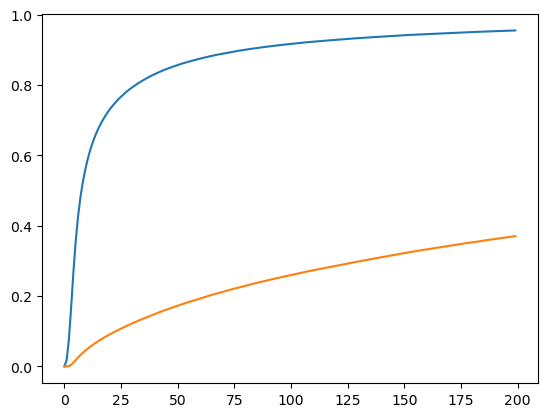

In [11]:
track_counts_relation = list()
like_counts_relation = list()
len_track_artist = len(track_artists)
like_count_sum = track_artists['test_track_counts'].sum()

for i in range(200):
    track_counts_relation.append((track_artists['test_track_counts']<i).sum()/len_track_artist)
    like_counts_relation.append(track_artists[track_artists['test_track_counts']<i]['test_track_counts'].sum()/like_count_sum)
track_counts_relation = np.asarray(track_counts_relation)
like_counts_relation = np.asarray(like_counts_relation)

sns.lineplot(x=range(200),y=track_counts_relation)
sns.lineplot(x=range(200),y=like_counts_relation)

rare_like_limit = (like_counts_relation < RARE_LIKE_RATIO).sum()

print(f'Доля треков, создающая {RARE_LIKE_RATIO} самых редких лайков в тестовой выборке: {(track_artists["test_track_counts"]<(like_counts_relation < RARE_LIKE_RATIO).sum()).sum()/len(track_artists)}')
print(f'Граница количества лайков, для треков создающих {RARE_LIKE_RATIO} редких лайков в тестовой выборке: {rare_like_limit}')

### Стобец `del_track` обозначает треки на удаление.

In [12]:
track_artists['del_track']=track_artists['test_track_counts']<rare_like_limit
track_artists_del = (track_artists[track_artists['del_track'] == True]['trackId']).astype('int32')

### Создание словаря столбец `vocab` в таблице `track_artists`

In [13]:
track_artists = track_artists[~track_artists['del_track']].reset_index()
track_artists['vocab'] = list(range(1,len(track_artists)+1))

### Приведение типов в таблице `track_artists`

In [14]:
track_artists['trackId'] = track_artists['trackId'].astype('int')
track_artists['artistId'] = track_artists['artistId'].astype('int')

In [85]:
track_artists.head(2)

,index,trackId,artistId,train_track_counts,test_track_counts,del_track,vocab
0,0,85862,52933,103,28,False,1
1,4,346334,24922,243,59,False,2


### Создание таблицы `artist_tracks`

In [17]:
artist_tracks = track_artists.pivot_table(index='artistId', values=['train_track_counts','test_track_counts'], aggfunc='sum')
artist_tracks['counts'] = artist_tracks['train_track_counts'] + artist_tracks['test_track_counts']

### Создание словаря столбец `vocab` в таблице `artist_tracks`

In [18]:
artist_tracks.reset_index(inplace=True)
artist_tracks['vocab'] = list(range(1,len(artist_tracks)+1))

In [ ]:
artist_tracks.head(2)

### Разбиение таблиц `train`, `test` на треки

In [20]:
train = splitting_tracks(train)

100%|██████████| 1160084/1160084 [00:20<00:00, 57853.31it/s]


In [21]:
test = splitting_tracks(test)

100%|██████████| 289914/289914 [00:05<00:00, 57842.55it/s]


### Удаление из `train`, `test` треков `del_track`

In [22]:
train = tracks_del_track(track_artists_del, train)

100%|██████████| 1160084/1160084 [00:07<00:00, 154677.98it/s]


In [23]:
test = tracks_del_track(track_artists_del, test)

100%|██████████| 289914/289914 [00:01<00:00, 153566.87it/s]


### Создание таблиц `train_artists`, `test_artists`
Замена id треков, на id артистов.

In [ ]:
train_artists = create_artists(train, track_artists)

In [ ]:
test_artists = create_artists(test, track_artists)

### Создание таблиц `all_tracks` и `all_artists`
Объединение датасетов train + test

In [25]:
all_tracks = np.concatenate((train, test), axis=0)
all_artists = np.concatenate((train_artists, test_artists), axis=0)
all_tracks.shape, all_artists.shape
del train, train_artists

### Сохранение/загрузка таблиц `all_tracks`, `all_artists`, `test`, `test_artists`.

### Применение словаря к `all_tracks`, `all_artists`, `test`, `test_artists`.

In [ ]:
all_tracks_vocab = vocab_use(all_tracks, track_artists, 'trackId')
all_artists_vocab = vocab_use(all_artists, artist_tracks, 'artistId')
test_vocab = vocab_use(test, track_artists, 'trackId')
test_artists_vocab = vocab_use(test_artists, artist_tracks, 'artistId')
del all_tracks, all_artists, test, test_artists

### Сохранение/загрузка таблиц `all_tracks_vocab`, `all_artists_vocab`, `test_vocab`, `test_artists_vocab`.

In [14]:
all_tracks_vocab = np.load('data/all_tracks_vocab.npy')
all_artists_vocab = np.load('data/all_artists_vocab.npy')
test_vocab = np.load('data/test_vocab.npy')
test_artists_vocab = np.load('data/test_artists_vocab.npy')

### Выделение `last_like` в качестве целевой функции

In [13]:
last_like = np.zeros(len(all_tracks_vocab),  dtype='int32')
del_index_row = list()
for i in tqdm(range(len(last_like))):
    for j in range(256):
        if all_tracks_vocab[i][j] == 0:
            if j in [0]:
                del_index_row.append(i)
                break
            last_like[i] = all_tracks_vocab[i][j-1]
            all_tracks_vocab[i][j-1] = 0
            all_artists_vocab[i][j-1] = 0
            break
        if j == 255:
            last_like[i] = all_tracks_vocab[i][j]
            all_tracks_vocab[i][j] = 0
            all_artists_vocab[i][j] = 0

100%|██████████| 1449998/1449998 [00:49<00:00, 29278.69it/s]


In [14]:
print(f'Число строк на удаление {len(del_index_row)}')
print(f'Останется строк {len(last_like) - len(del_index_row)}')

Число строк на удаление 2224
Останется строк 1447774


### Удаление строк в `last_like`, `all_tracks_vocab`, `all_artists_vocab`.

In [15]:
all_tracks_vocab = np.delete(all_tracks_vocab, del_index_row, axis=0)
all_artists_vocab = np.delete(all_artists_vocab, del_index_row, axis=0)
last_like = np.delete(last_like, del_index_row, axis=0)
del del_index_row

In [16]:
all_tracks_vocab.shape, all_artists_vocab.shape, last_like.shape

((1447774, 256), (1447774, 256), (1447774,))

## Создание эмбеддингов

### Создание сетки.

In [15]:
class CBOW_Model(nn.Module):
    def __init__(self, vocab_size_in, vocab_size_out):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(vocab_size_in, 192, padding_idx=0)
        self.norm = nn.LayerNorm((192,), eps=1e-12, elementwise_affine=True)
        self.drop = nn.Dropout(p=0.1, inplace=False)
        self.linear1 = nn.Linear(in_features=192, out_features=192, bias=True)        
#         self.linear2 = nn.Linear(in_features=EMB_DIM, out_features=3072, bias=True)
#         self.linear3 = nn.Linear(in_features=3072, out_features=EMB_DIM, bias=True)
        self.linear4 = nn.Linear(in_features=192, out_features=1536, bias=True)
        self.linear5 = nn.Linear(in_features=1536, out_features=192, bias=True)
        self.linear6 = nn.Linear(in_features=192, out_features=vocab_size_out)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = self.norm(x)
        x = self.drop(x)
        x = self.linear1(x)
        x = x.mean(axis=1)
        x = self.norm(x)
#         x = self.drop(x)
#         x = self.linear2(x)
#         x = F.gelu(x, approximate='none')
#         x = self.linear3(x)
#         x = self.norm(x)
        x = self.drop(x)
        x = self.linear4(x)
        x = F.gelu(x, approximate='none')
        x = self.linear5(x)
        x = self.norm(x)
        emb = x
        x = self.drop(x)
        x = self.linear6(x)
        return x, emb
    
    def inference(self, x):
        x, _ = self.forward(x)
        x = self.sm(x)
        return x

### DataLoader `all_tracks_vocab`

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(all_tracks_vocab, last_like, test_size=0.018, shuffle=True, random_state=RANDOM)
X_train_tensor = torch.tensor(X_train.astype('int32'))
y_train_tensor = torch.tensor(y_train.astype('int32')).type(torch.LongTensor)
X_valid_tensor = torch.tensor(X_valid.astype('int32'))
y_valid = y_valid.astype('int32')

train = data_utils.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

### Обучение на `all_tracks_vocab`.

In [19]:
vocab_size_in = len(all_tracks_vocab)+1
vocab_size_out = len(track_artists)+1

model_emb_tracks = CBOW_Model(vocab_size_in, vocab_size_out).to('cuda')

training(model_emb_tracks, train_loader, X_valid_tensor, y_valid, EPOCH, 'tracks')

Epoch: 0, loss: 10.443, mrr: 0.009
Epoch: 1, loss: 9.744, mrr: 0.013
Epoch: 2, loss: 9.329, mrr: 0.014
Epoch: 3, loss: 8.999, mrr: 0.017
Epoch: 4, loss: 8.720, mrr: 0.017
Epoch: 5, loss: 8.490, mrr: 0.018
Epoch: 6, loss: 8.288, mrr: 0.018
Epoch: 7, loss: 8.093, mrr: 0.018
Epoch: 8, loss: 7.898, mrr: 0.019
Epoch: 9, loss: 7.703, mrr: 0.018
Epoch: 10, loss: 7.507, mrr: 0.019
Epoch: 11, loss: 7.310, mrr: 0.018
Epoch: 12, loss: 7.113, mrr: 0.019
Epoch: 13, loss: 6.921, mrr: 0.018
Epoch: 14, loss: 6.733, mrr: 0.019
Epoch: 15, loss: 6.548, mrr: 0.018
Epoch: 16, loss: 6.368, mrr: 0.019
Epoch: 17, loss: 6.195, mrr: 0.018
Epoch: 18, loss: 6.029, mrr: 0.017
Epoch: 19, loss: 5.869, mrr: 0.018
Epoch: 20, loss: 5.722, mrr: 0.018
Epoch: 21, loss: 5.582, mrr: 0.017
Epoch: 22, loss: 5.449, mrr: 0.017
Epoch: 23, loss: 5.324, mrr: 0.017
Epoch: 24, loss: 5.210, mrr: 0.017


### DataLoader `all_artists_vocab`

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(all_artists_vocab, last_like, test_size=0.018, shuffle=True, random_state=RANDOM)
X_train_tensor = torch.tensor(X_train.astype('int32'))
y_train_tensor = torch.tensor(y_train.astype('int32')).type(torch.LongTensor)
X_valid_tensor = torch.tensor(X_valid.astype('int32'))
y_valid = y_valid.astype('int32')

train = data_utils.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

### Обучение на `all_artists_vocab`.

In [21]:
vocab_size_in = len(all_artists_vocab)+1
vocab_size_out = len(track_artists)+1

model_emb_artists = CBOW_Model(vocab_size_in, vocab_size_out).to('cuda')

training(model_emb_artists, train_loader, X_valid_tensor, y_valid, EPOCH, 'artists')

Epoch: 0, loss: 10.447, mrr: 0.009
Epoch: 1, loss: 9.697, mrr: 0.014
Epoch: 2, loss: 9.269, mrr: 0.016
Epoch: 3, loss: 8.971, mrr: 0.017
Epoch: 4, loss: 8.751, mrr: 0.017
Epoch: 5, loss: 8.567, mrr: 0.018
Epoch: 6, loss: 8.399, mrr: 0.019
Epoch: 7, loss: 8.237, mrr: 0.019
Epoch: 8, loss: 8.081, mrr: 0.018
Epoch: 9, loss: 7.925, mrr: 0.020
Epoch: 10, loss: 7.772, mrr: 0.018
Epoch: 11, loss: 7.622, mrr: 0.018
Epoch: 12, loss: 7.474, mrr: 0.018
Epoch: 13, loss: 7.329, mrr: 0.017
Epoch: 14, loss: 7.191, mrr: 0.018
Epoch: 15, loss: 7.059, mrr: 0.017
Epoch: 16, loss: 6.933, mrr: 0.017
Epoch: 17, loss: 6.818, mrr: 0.017
Epoch: 18, loss: 6.708, mrr: 0.017
Epoch: 19, loss: 6.609, mrr: 0.017
Epoch: 20, loss: 6.518, mrr: 0.017
Epoch: 21, loss: 6.434, mrr: 0.016
Epoch: 22, loss: 6.357, mrr: 0.017
Epoch: 23, loss: 6.285, mrr: 0.016
Epoch: 24, loss: 6.218, mrr: 0.016


## Предсказание на `test_vocab`.

In [18]:
test = data_utils.TensorDataset(torch.tensor(test_vocab.astype('int32')).to('cuda'))
test_loader = data_utils.DataLoader(test, batch_size=1, shuffle=False)

model_tracks = torch.load('model/model_emb_tracks_12_mrr_0.019')

tracks_logits = predicting(model_tracks, test_loader)

289914it [1:16:48, 62.90it/s]


In [19]:
np.save('data/tracks_logits', tracks_logits)

In [20]:
tracks_logits.shape

(289914, 300)

## Предсказание на `test_artists_vocab`.

In [21]:
test = data_utils.TensorDataset(torch.tensor(test_artists_vocab.astype('int32')).to('cuda'))
test_loader = data_utils.DataLoader(test, batch_size=1, shuffle=False)

model_artists = torch.load('model/model_emb_artists_9_mrr_0.020')

artists_logits = predicting(model_artists, test_loader)

289914it [1:17:34, 62.29it/s]


In [22]:
np.save('data/artists_logits', artists_logits)

In [23]:
artists_logits.shape

(289914, 300)

## Объединение предсказаний в итоговый результат

In [33]:
tracks_logits = np.load('data/tracks_logits.npy')
artists_logits = np.load('data/artists_logits.npy')

In [34]:
tracks_logits.shape, artists_logits.shape

((289914, 300), (289914, 300))

Устранение треков из тестовой выборки

In [35]:
tracks_logits_transp = pd.DataFrame(np.concatenate((tracks_logits,test_vocab), axis=1)).T

tracks_logits_transp_list = []
for i in tqdm(range(len(tracks_logits_transp.T))):    
    tracks_logits_transp_list.append(tracks_logits_transp[i].drop_duplicates(keep=False)[:100])
tracks_logits = np.array(tracks_logits_transp_list)

artists_logits_transp = pd.DataFrame(np.concatenate((artists_logits,test_vocab), axis=1)).T

artists_logits_transp_list = []
for i in tqdm(range(len(artists_logits_transp.T))):    
    artists_logits_transp_list.append(artists_logits_transp[i].drop_duplicates(keep=False)[:100])
artists_logits = np.array(artists_logits_transp_list)

100%|██████████| 289914/289914 [00:42<00:00, 6785.40it/s]


Смешивание логитов tracks и artists: 0,0,1,1,2,2... 49,49

In [36]:
all_logits = np.zeros((289914, 200))
for i in tqdm(range(100)): #по строкам
    all_logits[:,i*2] = tracks_logits[:,i]
    all_logits[:,i*2+1] = artists_logits[:,i]

100%|██████████| 100/100 [00:00<00:00, 168.07it/s]


In [37]:
all_logits.shape

(289914, 200)

Обрезка логитов до 100 с устранением дубликатов

In [40]:
all_logits_transp = pd.DataFrame(all_logits).T

all_logits_transp_list = []
for i in tqdm(range(len(all_logits_transp.T))):    
    all_logits_transp_list.append(all_logits_transp[i].drop_duplicates(keep='first')[:100])
all_logits = np.array(all_logits_transp_list)

100%|██████████| 289914/289914 [00:42<00:00, 6880.86it/s]


Обратное применеие словаря

In [41]:
tracks_vocab_cp = cp.array(track_artists[['trackId','vocab']].values, dtype='int32')
predict_tracks_cp = cp.array(all_logits, dtype='int32')

for i in tqdm(range(len(tracks_vocab_cp))):
    predict_tracks_cp = cp.where(predict_tracks_cp == tracks_vocab_cp[i][1], x=tracks_vocab_cp[i][0], y=predict_tracks_cp)

100%|██████████| 118781/118781 [01:18<00:00, 1520.41it/s]


In [42]:
predict_tracks_cp.shape

(289914, 100)

## Сохранение сабмита

In [43]:
np.savetxt('data/result_top100', predict_tracks_cp, fmt='%d', delimiter=' ', newline='\n', header='', footer='', comments='', encoding=None)